This file tests the federated framework installation. If anything gets stuck look into the logging file (testing/loging.log)

In [1]:
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
import os
os.chdir('/home/schneebi/PycharmProjects/federated-learning/Federated-Learning') 
import sys
os.environ['STATIC_VARIABLES_FILE_PATH'] = "globalserver/static_variables.json"
os.environ['PATH_TO_GLOBALSERVER'] = "globalserver/api/"
sys.path.append(os.getcwd())
import json

# Importing the required Keras modules containing model and layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense



from examples.dummy_example.utils import get_data,save_data_as_json,plot_data

We first define the Model we want to run in a federated way and define all parameters.

In [2]:
def kkbox_nn(parameters):
    model = Sequential()
    layers = 5
    nodes = 16
    lr = 0.01

    for i in range(layers):
        if i == 0:
            model.add(Dense(nodes, activation=tf.nn.relu, input_shape=(2,)))
        else:
            model.add(Dense(nodes, activation=tf.nn.relu))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=[tf.metrics.AUC()])
    model.summary()
    return model


clients = ["r1","r0"]


setup_dict = {"model_function": {
    "function": kkbox_nn,
    "parameters": {
    }
},
    "git_version": 'e9339081b76ad3a89b1862bd38d8af26f0541f1c',
    "protocol": 'NN',
    "model_name": "test_model",
    "model_description": "this model is just to test the db",
    "testing": True,
    "training_config": {
        'epochs':  10,
        'verbose': 2,
        'batch_size': 100,
        "validation_steps": 40,
        # "dataset":'1',
        "test_steps": 40,
        "steps_per_epoch": 20,#int(14679/1000),
        "skmetrics": [],
        "tfmetrics": ["AUC", "Accuracy"],
        "differential_privacy": {"method": 'before',
                                 },


        # in the non-testing environment the data is streamed and thus we do not
        # know how many steps per epoch we can do. This number should be len(training)/batch_size

    },
    "rounds": 30,
    "round": ["fetch_model", "train_model", "send_model", "send_training_loss", "send_test_loss", "aggregate"],
    "final_round": ["fetch_model","send_test_loss", "send_training_loss"],
    "clients": clients,
    "experiment_name": "kkbox",
    "experiment_description": f"desc if nice experiment",
    "stop_function": None,
    "upkeep_function": None,
    "preprocessing": {
        "noise": {
            "epsilon": 10000,
            "delta": 1
        }
    },
}


Next we start the Workers and the Global Server. We also define a dummy set to train on and save it into the dataset folder.

In [3]:

from globalserver.operator_.operator_class_db import Operator
from testing.test_class import Testing

TestSetup = Testing(clients, start_servers=True, clear_logs=True, clear_db=False, interface=False)
operator = Operator()


training_data, client1_data_final,client2_data_final,y=get_data(exp=3)
test_data, _,_,_=get_data(seed=10,exp=3)
save_data_as_json(client1_data_final,client2_data_final,test_data)


2020-04-30 13:39:43,156 [MainProcess ] [INFO ] [OPERATOR] [test_class.py / kill_servers / 194] KILLING SERVERS
2020-04-30 13:39:43,159 [MainProcess ] [INFO ] [OPERATOR] [test_class.py / kill_global_server / 156] KILLING GLOBAL SERVER
2020-04-30 13:39:43,161 [MainProcess ] [INFO ] [OPERATOR] [test_class.py / kill_client_interface_node / 163] KILLING CLIENT INTERFACE NODE
2020-04-30 13:39:43,163 [MainProcess ] [INFO ] [OPERATOR] [test_class.py / kill_client_interface / 173] KILLING CLIENT INTERFACE
2020-04-30 13:39:43,165 [MainProcess ] [INFO ] [OPERATOR] [test_class.py / kill_node_servers / 183] KILLINGCLIENTS
2020-04-30 13:39:46,321 [MainProcess ] [INFO ] [OPERATOR] [test_class.py / start_global_server / 337] STARTING UP GLOBAL SERVER
2020-04-30 13:39:46,341 [MainProcess ] [INFO ] [OPERATOR] [test_class.py / start_node_servers / 225] STARTING UP NODES


the commandline is ['/home/schneebi/PycharmProjects/federated-learning/venv/bin/python', 'api/globalserver_task_controller.py', 'C88A33B946']
the commandline is ['/home/schneebi/PycharmProjects/federated-learning/venv/bin/python', 'node_task_controller.py', 'r1', 'C88A33B946']
the commandline is ['/home/schneebi/PycharmProjects/federated-learning/venv/bin/python', 'node_task_controller.py', 'r0', 'C88A33B946']


Finally, we run the experiment for the two single clients and together in a federated way.

In [4]:
models={}
for clients in [["r1","r0"],["r1"],["r0"]]:
    setup_dict["clients"]= clients
    experiment_id,_=operator.define_and_start_experiment(setup_dict)
    model=operator.get_compiled_model(protocol='NN', experiment_id=experiment_id)
    
    models[f'{clients}']=model

2020-04-30 13:40:03,971 [MainProcess ] [DEBUG] [OPERATOR] [cmd.py / execute / 719] Popen(['git', 'version'], cwd=/home/schneebi/PycharmProjects/federated-learning/Federated-Learning, universal_newlines=False, shell=None, istream=None)
2020-04-30 13:40:03,983 [MainProcess ] [DEBUG] [OPERATOR] [cmd.py / execute / 719] Popen(['git', 'version'], cwd=/home/schneebi/PycharmProjects/federated-learning/Federated-Learning, universal_newlines=False, shell=None, istream=None)
2020-04-30 13:40:03,995 [MainProcess ] [DEBUG] [OPERATOR] [cmd.py / execute / 719] Popen(['git', 'cat-file', '--batch-check'], cwd=/home/schneebi/PycharmProjects/federated-learning/Federated-Learning, universal_newlines=False, shell=None, istream=<valid stream>)
2020-04-30 13:40:04,133 [MainProcess ] [INFO ] [OPERATOR] [operator_class_db.py / start_experiment / 171] 5eaab914ac0425f0caba3c01
2020-04-30 13:40:04,136 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
______________________________________________________

2020-04-30 13:40:19,158 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaab914ac0425f0caba3c05'), 'task_order': 3, 'task_name': 'send_training_loss', 'task_status': 'scheduled'}
2020-04-30 13:40:24,166 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaab914ac0425f0caba3c07'), 'task_order': 5, 'task_name': 'aggregate', 'task_status': 'not_scheduled'}
2020-04-30 13:40:24,168 [MainProcess ] [INFO ] [OPERATOR] [operator_class_db.py / aggregate / 254] Aggregating...
2020-04-30 13:40:29,198 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaab914ac0425f0caba3c0b'), 'task_order': 9, 'task_name': 'send_training_loss', 'task_status': 'scheduled'}
2020-04-30 13:40:34,207 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaab914ac0425f0caba3c0d'),

2020-04-30 13:42:34,807 [MainProcess ] [INFO ] [OPERATOR] [operator_class_db.py / aggregate / 254] Aggregating...
2020-04-30 13:42:40,036 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaab914ac0425f0caba3c59'), 'task_order': 87, 'task_name': 'send_training_loss', 'task_status': 'scheduled'}
2020-04-30 13:42:45,042 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaab914ac0425f0caba3c5b'), 'task_order': 89, 'task_name': 'aggregate', 'task_status': 'not_scheduled'}
2020-04-30 13:42:45,043 [MainProcess ] [INFO ] [OPERATOR] [operator_class_db.py / aggregate / 254] Aggregating...
2020-04-30 13:42:50,054 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaab914ac0425f0caba3c5f'), 'task_order': 93, 'task_name': 'send_training_loss', 'task_status': 'scheduled'}
2020-04-30 13:42:55,060 [MainProcess ] [DEBUG

2020-04-30 13:44:55,463 [MainProcess ] [INFO ] [OPERATOR] [operator_class_db.py / aggregate / 254] Aggregating...
2020-04-30 13:45:00,590 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaab914ac0425f0caba3cad'), 'task_order': 171, 'task_name': 'send_training_loss', 'task_status': 'scheduled'}
2020-04-30 13:45:05,600 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaab914ac0425f0caba3caf'), 'task_order': 173, 'task_name': 'aggregate', 'task_status': 'not_scheduled'}
2020-04-30 13:45:05,602 [MainProcess ] [INFO ] [OPERATOR] [operator_class_db.py / aggregate / 254] Aggregating...
2020-04-30 13:45:10,634 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaab914ac0425f0caba3cb3'), 'task_order': 177, 'task_name': 'send_training_loss', 'task_status': 'scheduled'}
2020-04-30 13:45:15,641 [MainProcess ] [DE

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
____________________________________________________

2020-04-30 13:45:36,086 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaaba50ac0425f0caba3cbd'), 'task_order': 1, 'task_name': 'train_model', 'task_status': 'scheduled'}
2020-04-30 13:45:41,090 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaaba50ac0425f0caba3cc0'), 'task_order': 4, 'task_name': 'send_test_loss', 'task_status': 'scheduled'}
2020-04-30 13:45:46,094 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaaba50ac0425f0caba3cc1'), 'task_order': 5, 'task_name': 'aggregate', 'task_status': 'not_scheduled'}
2020-04-30 13:45:46,095 [MainProcess ] [INFO ] [OPERATOR] [operator_class_db.py / aggregate / 254] Aggregating...
2020-04-30 13:45:51,111 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaaba50ac0425f0caba3cc5'), 'task_orde

2020-04-30 13:47:56,519 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaaba51ac0425f0caba3d0f'), 'task_order': 83, 'task_name': 'aggregate', 'task_status': 'not_scheduled'}
2020-04-30 13:47:56,521 [MainProcess ] [INFO ] [OPERATOR] [operator_class_db.py / aggregate / 254] Aggregating...
2020-04-30 13:48:01,541 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaaba51ac0425f0caba3d13'), 'task_order': 87, 'task_name': 'send_training_loss', 'task_status': 'scheduled'}
2020-04-30 13:48:06,547 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaaba51ac0425f0caba3d15'), 'task_order': 89, 'task_name': 'aggregate', 'task_status': 'not_scheduled'}
2020-04-30 13:48:06,548 [MainProcess ] [INFO ] [OPERATOR] [operator_class_db.py / aggregate / 254] Aggregating...
2020-04-30 13:48:11,564 [MainProcess ] [DEBUG] [OP

2020-04-30 13:50:12,239 [MainProcess ] [INFO ] [OPERATOR] [operator_class_db.py / aggregate / 254] Aggregating...
2020-04-30 13:50:17,762 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaaba51ac0425f0caba3d60'), 'task_order': 164, 'task_name': 'send_model', 'task_status': 'scheduled'}
2020-04-30 13:50:22,766 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaaba51ac0425f0caba3d63'), 'task_order': 167, 'task_name': 'aggregate', 'task_status': 'not_scheduled'}
2020-04-30 13:50:22,767 [MainProcess ] [INFO ] [OPERATOR] [operator_class_db.py / aggregate / 254] Aggregating...
2020-04-30 13:50:27,778 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaaba51ac0425f0caba3d66'), 'task_order': 170, 'task_name': 'send_model', 'task_status': 'scheduled'}
2020-04-30 13:50:32,783 [MainProcess ] [DEBUG] [OPERATOR] 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_15 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_16 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
____________________________________________________

2020-04-30 13:51:03,269 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaabb9dac0425f0caba3d77'), 'task_order': 1, 'task_name': 'train_model', 'task_status': 'not_scheduled'}
2020-04-30 13:51:08,274 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaabb9dac0425f0caba3d79'), 'task_order': 3, 'task_name': 'send_training_loss', 'task_status': 'scheduled'}
2020-04-30 13:51:13,278 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaabb9dac0425f0caba3d7b'), 'task_order': 5, 'task_name': 'aggregate', 'task_status': 'not_scheduled'}
2020-04-30 13:51:13,279 [MainProcess ] [INFO ] [OPERATOR] [operator_class_db.py / aggregate / 254] Aggregating...
2020-04-30 13:51:18,291 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaabb9dac0425f0caba3d7f'), 't

2020-04-30 13:53:25,706 [MainProcess ] [INFO ] [OPERATOR] [operator_class_db.py / aggregate / 254] Aggregating...
2020-04-30 13:53:30,731 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaabb9dac0425f0caba3dcc'), 'task_order': 86, 'task_name': 'send_model', 'task_status': 'scheduled'}
2020-04-30 13:53:35,739 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaabb9dac0425f0caba3dcf'), 'task_order': 89, 'task_name': 'aggregate', 'task_status': 'not_scheduled'}
2020-04-30 13:53:35,740 [MainProcess ] [INFO ] [OPERATOR] [operator_class_db.py / aggregate / 254] Aggregating...
2020-04-30 13:53:40,751 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaabb9dac0425f0caba3dd3'), 'task_order': 93, 'task_name': 'send_training_loss', 'task_status': 'scheduled'}
2020-04-30 13:53:45,757 [MainProcess ] [DEBUG] [OPERA

2020-04-30 13:55:46,376 [MainProcess ] [INFO ] [OPERATOR] [operator_class_db.py / aggregate / 254] Aggregating...
2020-04-30 13:55:51,406 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaabb9dac0425f0caba3e21'), 'task_order': 171, 'task_name': 'send_training_loss', 'task_status': 'scheduled'}
2020-04-30 13:55:56,410 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaabb9dac0425f0caba3e23'), 'task_order': 173, 'task_name': 'aggregate', 'task_status': 'not_scheduled'}
2020-04-30 13:55:56,411 [MainProcess ] [INFO ] [OPERATOR] [operator_class_db.py / aggregate / 254] Aggregating...
2020-04-30 13:56:01,840 [MainProcess ] [DEBUG] [OPERATOR] [operator_utils.py / get_current_task / 96] Working on {'task_id': ObjectId('5eaabb9dac0425f0caba3e26'), 'task_order': 176, 'task_name': 'send_model', 'task_status': 'scheduled'}
2020-04-30 13:56:06,848 [MainProcess ] [DEBUG] [OP

First Plot is the results of the federated setup. 2nd and 3rd are the results of the single clients.

4000/1 - 0s - loss: 0.1261 - auc: 0.9819


/home/schneebi/PycharmProjects/federated-learning/Federated-Learning/examples/dummy_example/utils.py:91: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


4000/1 - 0s - loss: 0.1997 - auc_1: 0.9791
4000/1 - 0s - loss: 0.3639 - auc_2: 0.9485


2020-04-30 14:09:11,938 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1246] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2020-04-30 14:09:11,941 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
2020-04-30 14:09:11,942 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
2020-04-30 14:09:11,942 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
2020-04-30 14:09:11,943 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.

2020-04-30 14:09:11,988 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Tibetan Machine Uni' (TibetanMachineUni.ttf) normal normal 400 normal>) = 10.05
2020-04-30 14:09:11,988 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Kalimati' (kalimati.ttf) normal normal 400 normal>) = 10.05
2020-04-30 14:09:11,989 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Abyssinica SIL' (AbyssinicaSIL-R.ttf) normal normal 400 normal>) = 10.05
2020-04-30 14:09:11,989 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Ubuntu' (Ubuntu-BI.ttf) italic normal 700 normal>) = 11.335
2020-04-30 14:09:11,990 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Samanata' (samanata.ttf) normal normal 400 normal>) = 10.05
2020-04-30 14:09:11,990 [MainProcess ] [DE

2020-04-30 14:09:12,006 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
2020-04-30 14:09:12,007 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335
2020-04-30 14:09:12,007 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Padauk Book' (PadaukBook-Bold.ttf) normal normal 700 normal>) = 10.335
2020-04-30 14:09:12,008 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Pothana2000' (Pothana2000.ttf) normal normal 400 normal>) = 10.05
2020-04-30 14:09:12,008 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Norasi' (Norasi.ttf) normal normal 400 normal>) = 10.05
2020-04-30 14:09:12,009

2020-04-30 14:09:12,046 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Lohit Telugu' (Lohit-Telugu.ttf) normal normal 400 normal>) = 10.05
2020-04-30 14:09:12,047 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Garuda' (Garuda.ttf) normal normal 400 normal>) = 10.05
2020-04-30 14:09:12,048 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Umpush' (Umpush-Bold.ttf) normal normal 700 normal>) = 10.335
2020-04-30 14:09:12,048 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'FreeMono' (FreeMonoOblique.ttf) oblique normal 400 normal>) = 11.05
2020-04-30 14:09:12,049 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Noto Serif CJK JP' (NotoSerifCJK-Regular.ttc) normal normal 400 normal>) = 10.05
2020-04-30 14:09:12,050 [MainProcess ] [

2020-04-30 14:09:12,080 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Umpush' (Umpush-LightOblique.ttf) oblique normal light normal>) = 11.24
2020-04-30 14:09:12,080 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Manjari' (Manjari-Bold.otf) normal normal bold normal>) = 10.335
2020-04-30 14:09:12,081 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal 700 normal>) = 10.335
2020-04-30 14:09:12,081 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'RaghuMalayalam' (RaghuMalayalamSans-Regular.ttf) normal normal regular normal>) = 10.05
2020-04-30 14:09:12,082 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'KacstDecorative' (KacstDecorative.ttf) normal normal 400 normal>) = 10.

2020-04-30 14:09:12,112 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Lohit Gurmukhi' (Lohit-Gurmukhi.ttf) normal normal 400 normal>) = 10.05
2020-04-30 14:09:12,113 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335
2020-04-30 14:09:12,113 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'Lohit Tamil Classical' (Lohit-Tamil-Classical.ttf) normal normal 400 normal>) = 10.05
2020-04-30 14:09:12,114 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'FreeSans' (FreeSansBoldOblique.ttf) oblique normal 700 normal>) = 11.335
2020-04-30 14:09:12,114 [MainProcess ] [DEBUG] [OPERATOR] [font_manager.py / _findfont_cached / 1258] findfont: score(<Font 'FreeMono' (FreeMonoBoldOblique.ttf) oblique normal 700 norm

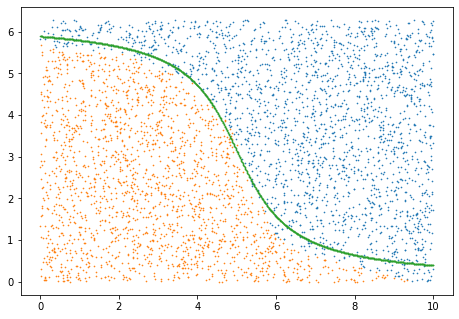

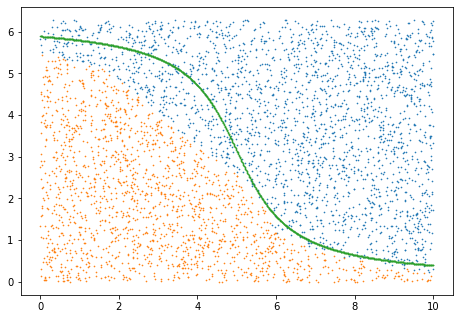

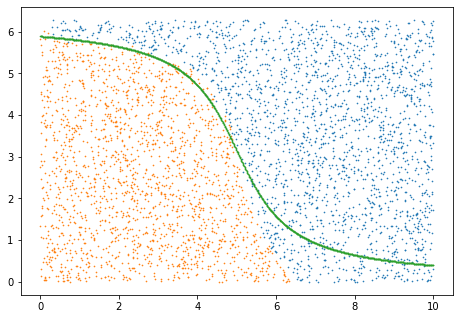

In [6]:
for clients,model in models.items():
    model.evaluate(x=test_data[:,0:2],y=test_data[:,2], verbose=2)
    y_pred=model.predict(x=test_data[:,:2])
    test_data[:, 2]=[1 if y[0]>0.5 else 0 for y in y_pred]

    plot_data([test_data[test_data[:,2]>0],test_data[test_data[:,2]<1],y])


You can see all results in the experiment collection in the database.